# Thermostat

Example taken from: https://arxiv.org/pdf/1410.8060

```
tOff = ?, tOn = ?

repeat {
    temp = readTemp()
    if isOn() and temp > tOff {
        isOn = False
    }
    else if not isOn() and temp < tOn {
        isOn = True
    }
}
```

Temperature evolves according to:
$$ \frac{d \textit{temp}}{dt} = \begin{cases} - \textit{temp} + 30 \, (+ \text{gauss}(0, \epsilon)) & \text{if isON} \\
                                              - \textit{temp} \, (+ \text{gauss}(0, \epsilon)) & \text{is not isOn}  \end{cases} $$

I generate temperature trajectories for $tOn =, tOff=, k=, h=, \epsilon=$ and try to synthesize $tOn, tOff$ using as loss the log-likelihood over trajectories.

## SOGA

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
print(sys.path)

from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *
from libSOGA import *
from time import time
import matplotlib.pyplot as plt
import numpy as np
import torch

['/home/romina/PhD/DEGAS/DeGAS/src/REACHABILITY', '/home/romina/anaconda3/lib/python39.zip', '/home/romina/anaconda3/lib/python3.9', '/home/romina/anaconda3/lib/python3.9/lib-dynload', '', '/home/romina/anaconda3/lib/python3.9/site-packages', '/home/romina/anaconda3/lib/python3.9/site-packages/IPython/extensions', '/home/romina/.ipython', '/home/romina/PhD/DEGAS/DeGAS/src']


In [2]:
from optimization import *
torch.set_default_dtype(torch.float64)

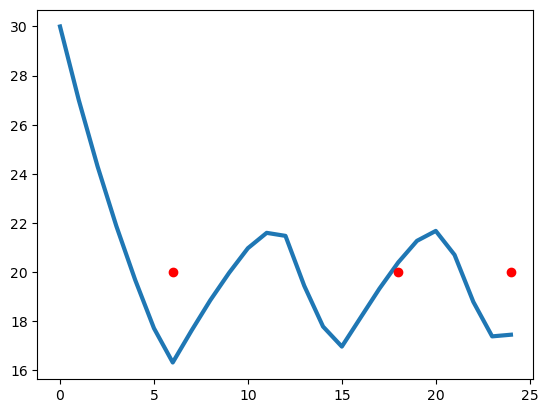

In [3]:
# this is to check that for the correct value of the parameter, the loss is negative and the mean produced by SOGA is almost exactly the true mean
orig_params = {'T': 25,   # time steps
               'init_T': 16.,  # initial temperature
               'tOn': 17,      # turn-on temperature
               'tOff': 20}     # turn-off temperature

soga_code = """
array[26] T;
array[26] M; 

/* Initial state */
currT = gauss(30., 1.);   
isOn = 1;                 

dt = 0.1;            

for i in range(25) {

    /* Save current state */
    T[i] = currT;
    M[i] = isOn;

    /* Continuous dynamics */
    if isOn > 0 {
        /* Cooling: dT/dt = -T */
        temp = currT * dt;
        newT = currT - temp + gauss(0., 0.1);
    } else {
        /* Heating: dT/dt = -(T-30) */
        temp = currT * dt;
        newT = currT - temp ;
        temp = 30. * dt;
        newT = newT + temp + gauss(0., 0.1);
    } end if;

    currT = newT;

    /* Mode switching */
    if isOn > 0 {
        if currT < _tOff {
            isOn = -1;
        } else {
            skip;
        } end if;
    } else {
        if currT >= _tOn {
            isOn = 1;
        } else {
            skip;
        } end if;
    } end if;

} end for;

/* Save final state */
T[25] = currT;
M[25] = isOn;

"""

compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)

# initialize parameters
T = orig_params['T']
init_T = orig_params['init_T']
params = {'tOff':  17., 'tOn':22.}
params_dict = initialize_params(params)  

# computes SOGA output
output_dist = start_SOGA(cfg, params_dict)

#plot
y_init = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_init, lw=3, label='SOGA w true params')
# Points to which the lines should be drawn
points = [(6, 20), (18, 20), (24, 20)]

# Plot the points on the graph
for point in points:
    plt.plot(point[0], point[1], 'ro')  # Red dot at each point
#plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')

In [4]:
output_dist.gm.marg_pdf(torch.tensor(1.).unsqueeze(0), idx = 40)

tensor([[191.6798]], grad_fn=<MmBackward0>)

In [5]:
output_dist.gm.mean()[26:51]

tensor([ 1.0000,  1.0000,  1.0000,  1.0000,  0.9999,  0.7496, -0.9529, -1.0000,
        -1.0000, -0.9995, -0.8156, -0.3585,  0.9238,  0.8101,  0.3590, -0.9187,
        -0.9941, -0.9998, -0.9470, -0.6878,  0.2045,  0.8956,  0.6847, -0.2031,
        -0.9440], grad_fn=<SliceBackward0>)

In [6]:
print(output_dist.gm.marg_pdf(torch.tensor(1.).unsqueeze(0), idx = int(np.round(0.6/0.1))+25))

tensor([[246.7708]], grad_fn=<MmBackward0>)


In [7]:
dt = 0.1
time_index_1 = int(np.round(0.6/dt))
print(time_index_1)
time_index_2 = int(np.round(1.8/dt))
print(time_index_2)
time_index_3 = int(np.round(2.4/dt))
print(time_index_3)


6
18
24


In [8]:
T_idx = [i for i in range(output_dist.gm.n_dim()) if 'T[' in output_dist.var_list[i]]
M_idx = [i for i in range(output_dist.gm.n_dim()) if 'M[' in output_dist.var_list[i]]

loss = lambda dist : -((dist.gm.marg_cdf(torch.tensor([20.1]), idx=int(np.round(0.6/dt))) - dist.gm.marg_cdf(torch.tensor([19.9]), idx=int(np.round(0.6/dt))))*dist.gm.marg_pdf(torch.tensor(-1.).unsqueeze(-1), idx = int(np.round(0.6/dt))+25).squeeze()
                       *(dist.gm.marg_cdf(torch.tensor([20.1]), idx=int(np.round(1.8/dt))) - dist.gm.marg_cdf(torch.tensor([19.9]), idx=int(np.round(1.8/dt))))*dist.gm.marg_pdf(torch.tensor(-1.).unsqueeze(-1), idx = int(np.round(1.8/dt))+25).squeeze()
                       *(dist.gm.marg_cdf(torch.tensor([20.1]), idx=int(np.round(2.4/dt))) - dist.gm.marg_cdf(torch.tensor([19.9]), idx=int(np.round(2.4/dt))))*dist.gm.marg_pdf(torch.tensor(-1.).unsqueeze(-1), idx = int(np.round(2.4/dt))+25).squeeze())
print(loss(output_dist))


tensor([[-0.0001]], grad_fn=<NegBackward0>)


/home/romina/anaconda3/lib/python3.9/site-packages/torch/autograd/graph.py:829: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


tOff: 17.09999976221181 tOn: 21.900000791072067  loss: -0.00014455606028489424
tOff: 17.1772964023861 tOn: 21.82080206626754  loss: -0.003968253312859312
tOff: 17.25029346863654 tOn: 21.73267783510205  loss: -0.027008003949580573
tOff: 17.322916862116994 tOn: 21.781548417720582  loss: -0.10517023635009165
tOff: 17.39305695149216 tOn: 21.849655205386373  loss: -0.3994424536119587
tOff: 17.46345362808317 tOn: 21.835084950163257  loss: -1.2052806424180498
tOff: 17.535040686429987 tOn: 21.844511307751716  loss: -3.223525294159043
tOff: 17.60826125144813 tOn: 21.89398064872715  loss: -7.7288251661789396
tOff: 17.68324022918005 tOn: 21.864893926044754  loss: -16.89329742341521
tOff: 17.761781473807247 tOn: 21.90621657530825  loss: -33.18853616028625
tOff: 17.84394761568775 tOn: 21.964250404313383  loss: -60.83492140152163
tOff: 17.93138420162167 tOn: 21.95412085608083  loss: -95.90526293204121
tOff: 18.022083364621306 tOn: 21.957359022485836  loss: -128.38129655347998
tOff: 18.101668370242 t

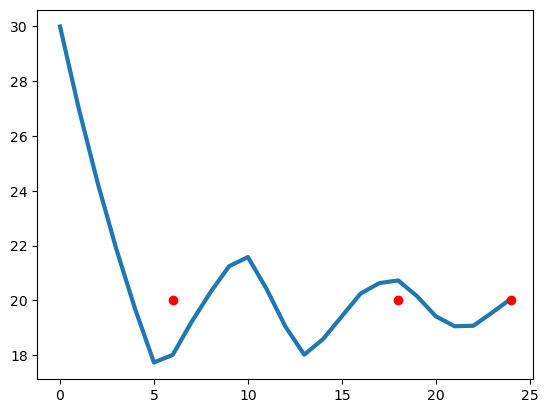

In [9]:
# Optimization in SOGA
# Define the optimizer with init_mean as the parameter
params_dict = initialize_params(params)

# gradient based optimization
optimize(cfg, params_dict, loss, n_steps=50, lr=0.1)

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")

compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict)
y_init = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_init, lw=3, label='SOGA w true params')

points = [(6, 20), (18, 20), (24, 20)]

# Plot the points on the graph
for point in points:
    plt.plot(point[0], point[1], 'ro')  # Red dot at each point